<a href="https://colab.research.google.com/github/KARENCMP82/Python/blob/main/4_PCA_CF_ANIME_RRB_26MAR25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nuclio Digital School - Máster en Data Science**

# Unsupervised Learning: Reducción de la dimensionalidad y Collaborative filtering

# *Profesora: Raquel Revilla*

<a id = "objetivos"></a>
# Objetivos del notebook
[Volver al índice](#toc)

Una de las áreas del machine learning con la cual interactuamos casi a diario son los modelos del Collaborative Filtering. Cada vez que nos conectamos a Instagram, Facebook, Amazon recibimos un feed personalizado de productos o servicios. En el notebook de esta sección, vamos a crear un feed personalizado para los fans de animes: **un feed estará basando en modelos de ML (KMeans)** y **otro feed será basado en la similitud de coseno.**

El dataset que vamos a utilizar es un dataset de Animes japoneses y se puede descargar en el siguiente [enlace](https://www.kaggle.com/CooperUnion/anime-recommendations-database)

![Data Model](https://drive.google.com/uc?export=view&id=11b0WFJxHM3R9Jm5ATir5f3OA_0h78Mu2)

Nuestros principales objetivos serán:
1. **Hacer una exploración inicial de los dos datasets** y entender la distribución de los datos.



2. **Procesar el dataset (eliminar usuarios sin puntuaciones).**



3. **Reducir la dimensionalidad de nuestro DataFrame utilizando el PCA.**


4. **Segmentar nuestros clientes utilizando el dataset reducido.**


5. **Utilizar la similitud del coseno para hacer recomendaciones a nuestro clientes (user and product based).**

<a id = "toc"></a>
# Índice

[Importación de las principales librerías](#import_modules)

[Importación de los datos](#import_data)

[Exploratory Data Analysis (EDA)](#eda)

---> [EDA anime df](#df1)

---> [EDA ratings df](#df2)

[Join final animes con ratings de usuarios](#join)

[Reducción de la dimensionalidad con PCA](#pca)

[Elbow curve, KMeans y recomendación basada en modelos de ML](#elbow_curve)

[Calculamos la similitud entre usuarios y productos](#colaborative_filtering)

[Recomendación "user based"](#recomendacion_usuarios)

[Recomendación "product based"](#recomendacion_animes)

[Conclusión](#conclusión)

<a id = "import_modules"></a>
# Importación de las principales librerías
[Volver al índice](#toc)

En esta sección del kernel vamos a cargar las principales librerías que vamos a usar en nuestro notebook.

In [4]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import math
import numpy as np
import pandas as pd

# scientific computations library
import scipy as sp

# loading ploting libraries
import matplotlib.pyplot as plt
%matplotlib inline

# import the function to compute cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
anime_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ejercicios/anime.csv")
rating_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ejercicios/rating.csv")

<a id = "import_data"></a>
# Importación de los datos
[Volver al índice](#toc)

En la presente sección del kernel vamos a cargar los principales datasets que vamos a usar para construir nuestro recomendador.

In [7]:
#PATH_ANIME = os.path.join(PATH_FOLDER, 'cf_anime.parquet.gzip')

#anime_df = pd.read_parquet(PATH_ANIME)

In [8]:
#PATH_RATING = os.path.join(PATH_FOLDER, 'cf_rating.parquet.gzip')

 #rating_df = pd.read_parquet(PATH_RATING)

<a id = "eda"></a>
# Exploratory Data Analysis (EDA)
[Volver al índice](#toc)

En la sección del EDA haremos **una primera aproximación a nuestros datos** para ver su composición y que variables tenemos a nuestra disposición.

<a id = "df1"></a>
# EDA anime df
[Volver al índice](#toc)

EDA rápido sobre el **dataset de anime.**

In [9]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [10]:
report_df(anime_df)

anime_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None

Tenemos un total de 317 nulos


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Observamos que tenemos algunos nulos y tendremos que lidiar con ellos.

In [11]:
anime_df.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


Por tipología de animes, vemos que el más popular es el de TV.

<Axes: title={'center': 'Anime by type'}, xlabel='type'>

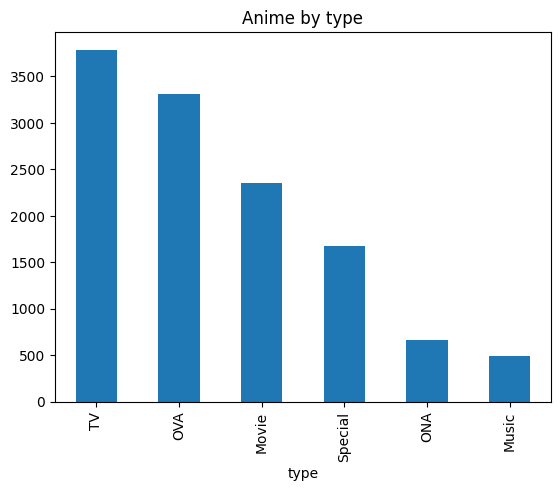

In [12]:
anime_df['type'].value_counts().plot(kind='bar', title = 'Anime by type')

In [13]:
anime_df.shape

(12294, 7)

In [14]:
anime_df = anime_df[anime_df['type'].isin(['TV', 'Movie'])]

In [15]:
anime_df.shape

(6135, 7)

En nuestro report_df hemos visto que **episodes** parecía que era númerico, pero podría contener otro tipos de datos (por ser object), convertimos a número esta columna.

In [16]:
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors = 'coerce')
anime_df['episodes'].fillna(1, inplace = True)

En la siguiente sección vamos a analizar la distribución de los animes en función del número de episodios que tenían.

In [17]:
count_per_episodes = anime_df['episodes'].value_counts().to_frame().reset_index()

In [18]:
count_per_episodes.columns = ['nr_episodes', 'nr_films']

In [19]:
count_per_episodes

,nr_episodes,nr_films
0,1.0,2524
1,12.0,751
2,13.0,518
3,26.0,497
4,52.0,175
...,...,...
181,1006.0,1
182,162.0,1
183,132.0,1
184,141.0,1


In [20]:
count_per_episodes.sort_values('nr_episodes', ascending = True, inplace = True)

In [21]:
count_per_episodes['pct_over_total'] = count_per_episodes['nr_films']/count_per_episodes['nr_films'].sum()

Casi la mitad de los animes es de un único episodio (41.14%).

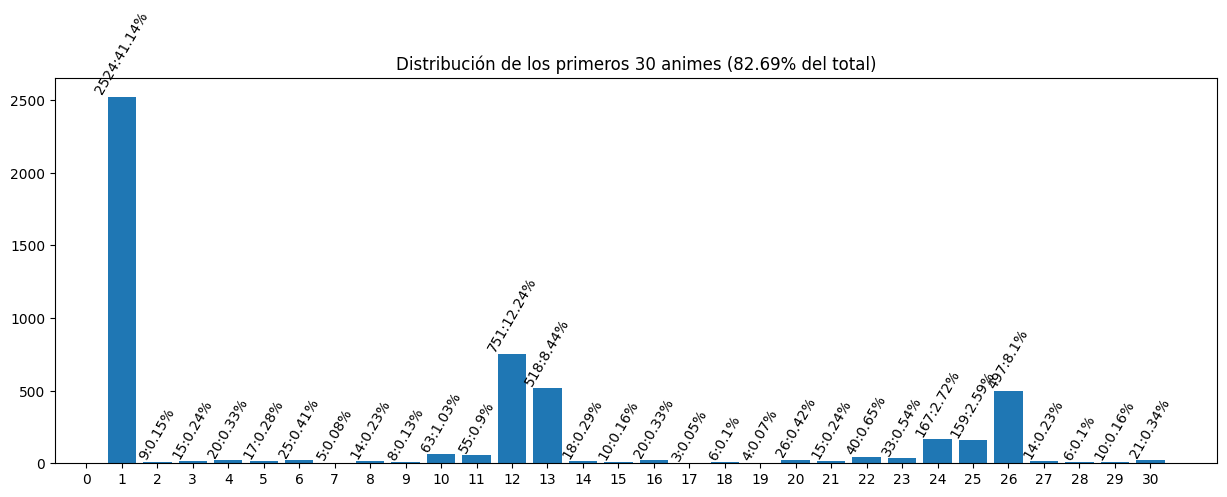

In [22]:
NR = 30

# instanciate the figure
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)

# separete the data
x = count_per_episodes["nr_episodes"].values[:NR]
y = count_per_episodes["nr_films"].values[:NR]
y_pct = count_per_episodes["pct_over_total"].values[:NR]

# plot the data
barplot = ax.bar(x, y)

# add text to each column
for rect, y_pct_ in zip(barplot, y_pct):
    y_pct_ = round(y_pct_*100, 2)
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width()/2.0,
        height,
        f"{height}:{y_pct_}%",
        ha = 'center',
        va = "bottom",
        rotation = 60
    )

# change the xticks
ax.set_xticks(np.arange(0, NR + 1))

# add title
total_y_pct = round(sum(y_pct)*100, 2)
ax.set_title(f"Distribución de los primeros {NR} animes ({total_y_pct}% del total)");

Vamos a realizar un análisis similar al anterior, pero ahora veremos como se distribuyen los animes en función de la puntuación media.

Para tener sólo 10 grupos, primero vamos a redondear la puntuación media.

In [23]:
anime_df['rating'].fillna(np.mean(anime_df['rating']), inplace = True)

In [24]:
anime_df['ceil_rating'] = anime_df['rating'].apply(lambda rating: np.round(rating, 0))
#redondeamos la variable

In [25]:
anime_df.tail(20)

,anime_id,name,genre,type,episodes,rating,members,ceil_rating
11097,34474,Tsukipro The Animation,NaN,TV,1.0,6.677433,843,7.0
11098,34498,"Uchiage Hanabi, Shita kara Miru ka? Yoko kara ...",Drama,Movie,1.0,6.677433,531,7.0
11099,34076,Uchouten Kazoku 2,"Comedy, Drama, Fantasy, Slice of Life",TV,1.0,6.677433,5934,7.0
11102,32924,Urara Meirochou,"Comedy, Seinen, Slice of Life",TV,1.0,6.677433,4305,7.0
11104,34522,"Wake Up, Girls! Shin Shou","Drama, Music",TV,1.0,6.677433,381,7.0
11106,34467,Yami Shibai 4th Season,"Dementia, Horror, Supernatural",TV,1.0,6.677433,1838,7.0
11107,32615,Youjo Senki,"Magic, Military",TV,1.0,6.677433,6652,7.0
11108,32222,Youkai Watch Movie 3: Soratobu Kujira to Doubl...,"Comedy, Kids, Supernatural",Movie,1.0,6.677433,237,7.0
11109,34471,Youkai Watch Movie 4,"Comedy, Kids, Supernatural",Movie,1.0,6.677433,169,7.0
11110,34284,Yuuki Yuuna wa Yuusha de Aru: Washio Sumi no Shou,"Drama, Fantasy, Magic, Slice of Life",TV,6.0,6.677433,2593,7.0


In [26]:
count_per_rating = anime_df['ceil_rating'].value_counts().to_frame().reset_index().sort_values('ceil_rating', ascending = True)

In [27]:
count_per_rating

,ceil_rating,count
8,2.0,2
6,3.0,31
4,4.0,218
3,5.0,561
1,6.0,1398
0,7.0,2685
2,8.0,1138
5,9.0,99
7,10.0,3


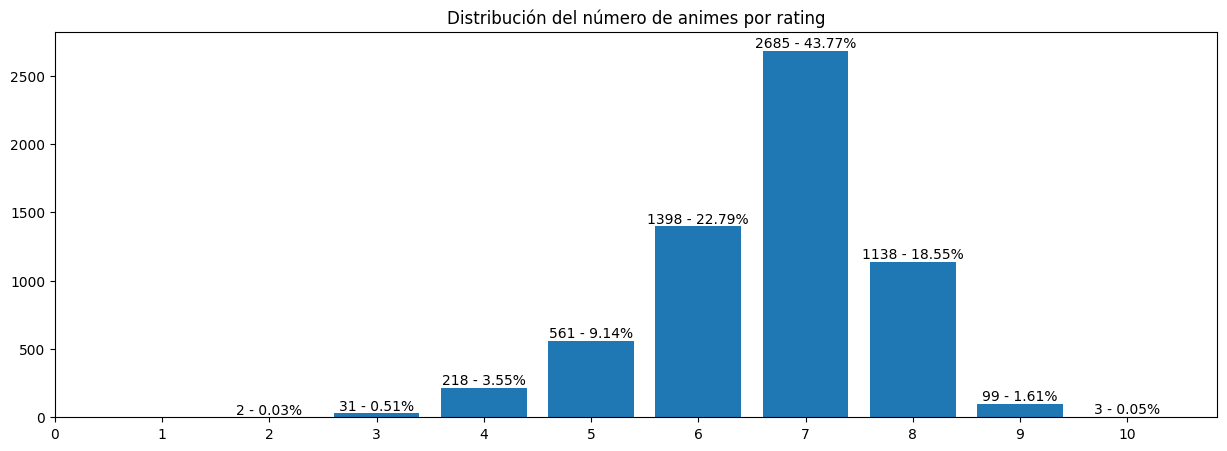

In [28]:
# instanciate the figure
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)

# separete the data
x = count_per_rating["ceil_rating"].values
y = count_per_rating["count"].values
y_pct = y/sum(y)

# plot the data
barplot = ax.bar(x, y)

# add text to each column
for rect, y_pct_ in zip(barplot, y_pct):
    y_pct_ = round(y_pct_*100, 2)
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width()/2.0,
        height,
        f"{height} - {y_pct_}%",
        ha = 'center',
        va = "bottom"
    )

ax.set_xticks(np.arange(0, 11))
ax.set_title("Distribución del número de animes por rating");

La puntuación más común es un 7 y se encuentra en 2.685 animes (43.77% del total).

<a id = "df2"></a>
# EDA ratings df
[Volver al índice](#toc)

EDA rápido sobre el DataFrame de **ratings de los animes.**

In [29]:
report_df(rating_df)

rating_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None

Tenemos un total de 0 nulos


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [30]:
rating_gb = rating_df['rating'].value_counts().reset_index().sort_values('rating', ascending = True)

In [31]:
rating_gb

,rating,count
1,-1,1476496
10,1,16649
9,2,23150
8,3,41453
7,4,104291
6,5,282806
5,6,637775
2,7,1375287
0,8,1646019
3,9,1254096


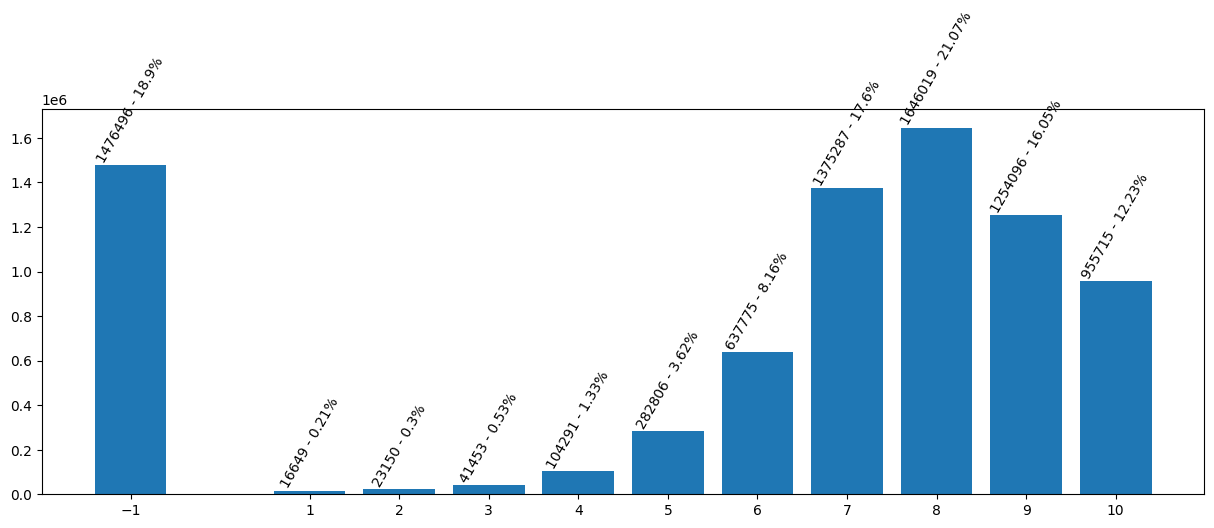

In [32]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot()

x = rating_gb["rating"]
y = rating_gb["count"]
y_pct = y/sum(y)

barplot = ax.bar(x, y)

# add text to each column
for rect, y_pct_ in zip(barplot, y_pct):
    y_pct_ = round(y_pct_*100, 2)
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width()/2.0,
        height,
        f"{height} - {y_pct_}%",
        ha = 'center',
        va = "bottom",
        rotation = 60
    )

ax.set_xticks(x);

Observamos que tenemos **casi un 19% de animes sin reviews.**

Vamos a ver los usuarios con más reviews.

In [33]:
user_pivot = rating_df['user_id'].value_counts()

user_pivot.head()

,count
user_id,
48766,10227
42635,3747
53698,2905
57620,2702
59643,2633


Vamos a eliminar de nuestro DataFrame a todos aquellos usuarios cuyo único review es -1.

In [34]:
s = rating_df.groupby('user_id')['rating'].apply(set)

 Agrupa las calificaciones por usuario y crea un conjunto único de calificaciones para cada usuario.

'rating_df.groupby('user_id')': Agrupa el DataFrame 'rating_df' por los valores únicos en la columna 'user_id'.
 Esto crea un objeto groupby donde cada grupo corresponde a un usuario único.

 ['rating']': Selecciona la columna 'rating' de cada grupo.
 Esto indica que se van a analizar las calificaciones dadas por cada usuario.

 .apply(set): Aplica la función 'set' a cada grupo de calificaciones.
 Para cada usuario, esto convierte la lista de calificaciones en un conjunto (set), lo que elimina cualquier calificación duplicada y crea un conjunto de calificaciones únicas hechas por ese usuario.
 El resultado es una Serie donde el índice es 'user_id' y el valor para cada usuario es un conjunto de las calificaciones que ha dado.

In [35]:
s

,rating
user_id,
1,"{10, -1}"
2,"{10, -1}"
3,"{3, 4, 5, 6, 7, 8, 9, 10, -1}"
4,{-1}
5,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}"
...,...
73512,"{5, 7, 8, 9, 10, -1}"
73513,"{5, 6, 7, 8, 9, 10}"
73514,{10}


In [36]:
user_id_no_reviews = s.to_frame()[s.to_frame()['rating'] == {-1}].index

In [37]:
user_id_no_reviews

Index([    4,     6,    13,    49,    54,    89,   133,   151,   157,   188,
       ...
       73296, 73300, 73335, 73407, 73411, 73418, 73447, 73451, 73467, 73475],
      dtype='int64', name='user_id', length=3915)

In [38]:
rating_df = rating_df[-rating_df['user_id'].isin(user_id_no_reviews)]

In [39]:
rating_df[rating_df['user_id'] == 73515]['rating'].value_counts()

,count
rating,
9,58
8,47
10,41
7,25
-1,17
6,7
5,1


<a id = "join"></a>
# Join final animes con ratings de usuarios
[Volver al índice](#toc)

Una vez que hemos analizado nuestros DataFrames, vamos a hacer un join **por anime_id.**

In [40]:
rating_df.head(2)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1


In [41]:
anime_df.head(2)

,anime_id,name,genre,type,episodes,rating,members,ceil_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0


Tenemos pintado las 2 tablas, las vamos a unir por anime_id, pero renombrando rating, en la linea de abajo vemos como lo renombramos


In [42]:
rating_df.rename(columns = {'rating':'user_rating'}, inplace = True)
anime_df.rename(columns = {'rating':'average_rating'}, inplace = True)

In [43]:
df_final = pd.merge(rating_df, anime_df, on = 'anime_id')

In [44]:
df_final.head()

,user_id,anime_id,user_rating,name,genre,type,episodes,average_rating,members,ceil_rating
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,8.0
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26.0,8.06,178553,8.0
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24.0,7.31,158772,7.0
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511,8.0
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11.0,6.69,84395,7.0


In [45]:
df_final = df_final.pivot_table(
    index = 'user_id',
    columns = 'name',
    values = 'user_rating'
)

In [46]:
df_final.head(20)

name,"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Trilogy,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//The Movie: Sekai no Mukou ni,009 Re:Cyborg,009-1,00:08,...,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_final.fillna(-1, inplace = True)

In [48]:
df_final.shape

(69421, 4957)

<a id = "pca"></a>
# Reducción de la dimensionalidad con PCA
[Volver al índice](#toc)

El PCA es el método más utilizado de reducción de la dimensionalidad y con una largo desarrollo teórico detrás (fue [inventado en 1901](https://en.wikipedia.org/wiki/Principal_component_analysis) por Karl Pearson).


El PCA no requiere mantener las definiciones del espacio original de atributos. Intuitivamente, se basa en la siguiente idea: dada una colección de puntos en dos o más dimensiones, puede definirse una línea con un ajuste óptimo que minimice la suma de distancias cuadráticas de cada punto a la línea. Definida esta línea, se puede definir una nueva línea perpendicular a ésta y repetir este proceso hasta construir una base ortogonal que llamaremos Componentes Principales, en la cuál podemos expresar todas las variables de manera que un subconjunto reducido de componentes nos permite explicar la mayor parte de la varianza del problema original.

Vamos a ver un ejemplo muy sencillo en 2 dimensiones para coger la intuición detrás del PCA:

![PCA](https://drive.google.com/uc?export=view&id=14zcKhX9ICCpZ6BF0j3BFHAQsZMaXQjIa)

Cuando inicializamos el PCA de sklearn, le tenemos que especificar el número de componentes que queremos que tenga nuestro nuevo dataset.

In [49]:
st = time.time()

pca = PCA(n_components = 30)
pca.fit(df_final)
pca_x = pca.transform(df_final)

pca_df = pd.DataFrame(
    data = pca_x,
    index = df_final.index,
    columns = ["PC_{}".format(i + 1) for i in range(30)]
)

et = time.time()
print("Total PCA took {} minutes".format(round((et - st)/60, 2)))

Total PCA took 0.59 minutes


In [50]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30
user_id,,,,,,,,,,,,,,,,,,,,,
1,-19.542481,-7.119551,-4.755393,-0.648731,-2.192734,-1.199661,-1.252375,-0.985422,3.027303,-1.827083,...,1.338297,-2.337489,-0.805899,1.377014,0.658767,-1.173640,-0.122748,0.313213,0.426051,-0.083129
2,-22.083560,-4.858830,-2.737407,-2.551677,-0.187485,-4.035947,-3.358467,-3.494109,-1.182784,-1.815868,...,-0.557872,1.417781,-0.006659,0.595684,-1.063073,0.927877,0.410534,0.848726,0.768021,-0.230781
3,5.083020,-14.778746,18.640514,18.980894,2.187618,-1.094115,9.560937,-2.326823,-2.150821,-0.691699,...,-8.275304,4.226459,-9.396494,10.892218,-5.547375,2.989095,-0.830505,3.718063,6.315670,3.215502
5,33.559928,-9.080567,1.897586,2.684388,-1.226394,-17.256201,14.924255,-20.594840,-11.921804,-21.452575,...,-16.841562,7.268159,1.351409,5.396559,-4.573084,-4.782790,-6.331626,-1.414677,-5.495656,-6.163842
7,38.711711,-22.091674,-14.769864,-4.282591,-17.027422,-20.436104,21.048498,5.882192,-1.638958,21.233445,...,6.672627,14.148505,0.258243,9.621315,16.754098,1.663810,-7.830639,-2.952850,-0.916134,-9.328407


Una vez fiteado el algoritmo de PCA, podemos mirar el átributo de **explained_variance_ratio_**.

Este átributo nos dice cuanta varianza explica cada uno de los componentes/columnas del nuevo dataset, del dataset original.

**Por ejemplo: el primer componente, contiene el 12% de la varianza original.**

In [51]:
pca.explained_variance_ratio_

array([0.12474883, 0.03927525, 0.02433784, 0.01844973, 0.01704202,
       0.01405951, 0.01064937, 0.00955457, 0.00889327, 0.00790785,
       0.00661037, 0.00627419, 0.00596753, 0.00549267, 0.00496128,
       0.00490119, 0.0045943 , 0.00450788, 0.00406223, 0.00400675,
       0.00398652, 0.00392508, 0.00379862, 0.00370301, 0.00350564,
       0.00347583, 0.00337501, 0.00318208, 0.00311944, 0.00299804])

In [52]:
sum(pca.explained_variance_ratio_)

np.float64(0.36136591177436206)

**Con 30 componentes, explicamos el 36% de la varianza original. Puede parecer "poca" pero tenemos que tener en cuenta que pasamos de 4.957 columnas a 30.**

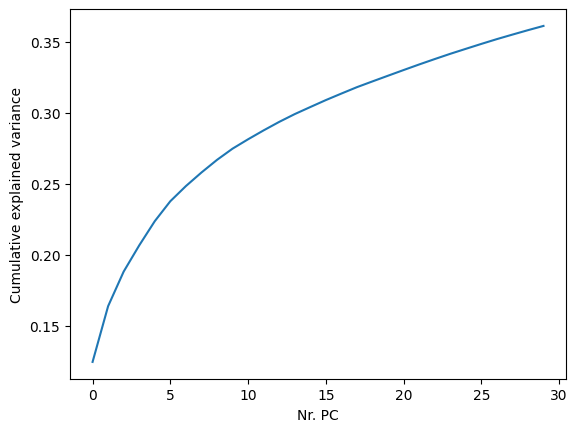

In [53]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nr. PC')
plt.ylabel('Cumulative explained variance');

<a id = "elbow_curve"></a>
# Elbow curve, KMeans y recomendación basada en modelos de ML
[Volver al índice](#toc)

Dado que ahora podemos reducir nuestro dataset. Podemos utilizar el algoritmo KMeans y segmentar a nuestros clientes utilizando el pca_df.

In [54]:
st = time.time()

sse = {}

for k in range(2, 8):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pca_df)
    sse[k] = kmeans.inertia_

et = time.time()
print("Total Elbow curve took {} minutes".format(round((et - st)/60, 2)))

Total Elbow curve took 0.03 minutes


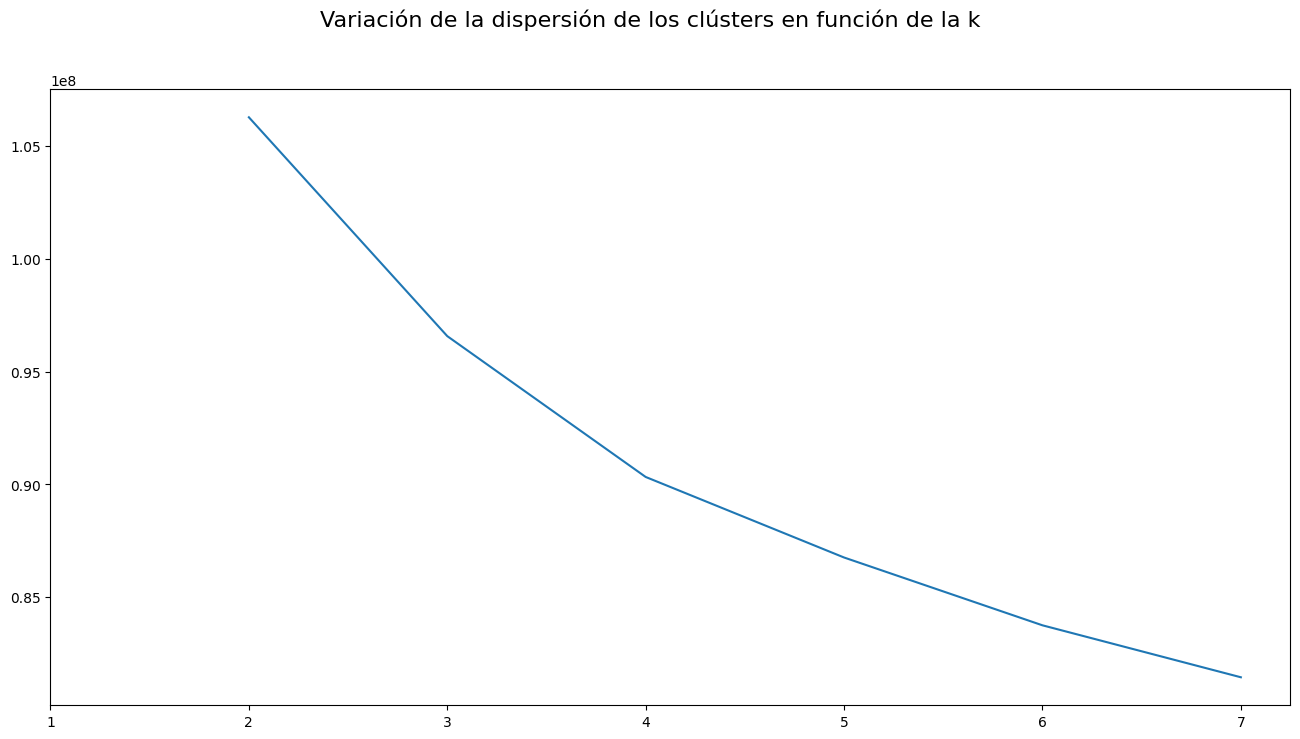

In [55]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
ax.set_xticks(np.arange(1, 8))
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [56]:
kmeans = KMeans(n_clusters = 4, random_state = 175)

In [57]:
kmeans.fit(pca_df)

KMeans(n_clusters=4, random_state=175)

In [58]:
df_final['cluster'] = kmeans.labels_

In [59]:
df_final.head()

name,"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Trilogy,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//The Movie: Sekai no Mukou ni,009 Re:Cyborg,009-1,00:08,...,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3
5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,3
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3


Ahora tenemos, a nuestros clientes **segmentados** y podemos llegar a plantear un recommendador de animes, en base al clúster que pertenece cada persona.

In [60]:
df_final.groupby('cluster').size()

,0
cluster,
0,44801
1,3651
2,9022
3,11947


In [61]:
cluster_ = df_final[df_final['cluster'] == 1]

In [62]:
cluster_.head()

name,"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Trilogy,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//The Movie: Sekai no Mukou ni,009 Re:Cyborg,009-1,00:08,...,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
17,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,8.0,6.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
43,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,7.0,7.0,-1.0,1
46,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
210,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
226,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,7.0,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,1


In [63]:
cluster_.drop('cluster', axis = 1, inplace = True)

In [64]:
cluster_.replace([-1], np.nan, inplace = True)

**RECORDAD:** La función melt en pandas se utiliza para transformar un DataFrame de un formato amplio (wide) a un formato largo (long). Esto es particularmente útil cuando se desea reorganizar datos para que las variables sean mejor representadas para análisis o visualización.

En un DataFrame en formato amplio, cada variable tiene su propia columna. En el formato largo, hay dos columnas clave: una para las variables y otra para los valores.

In [65]:
random_user = np.random.choice(cluster_.index)

In [66]:
melted_df = cluster_.melt()

In [67]:
melted_df.dropna(inplace = True)

In [68]:
melted_df = melted_df[melted_df['name'] != 'cluster']

In [69]:
average_score_cluster_ = melted_df.groupby('name').agg(
    score_medio = ('value', np.mean),
    nr_reviews = ('value', len)
)

In [70]:
average_score_cluster_.head()

,score_medio,nr_reviews
name,,
&quot;Bungaku Shoujo&quot; Movie,7.947552,572
.hack//G.U. Trilogy,7.328889,225
.hack//Roots,7.106952,374
.hack//Sign,7.158155,607
.hack//Tasogare no Udewa Densetsu,6.774648,355


In [71]:
average_score_cluster_.sort_values('nr_reviews', ascending = False, inplace = True)

In [86]:
def build_recommendation_for_user_cluster_based(
    average_score_cluster_,
    cluster_,
    user_id,
    nr_recommendations = 10,
    verbose = True):
    '''
    Construye una recomendación personal para un usuario basada en la mejor puntuación en el clúster al que pertenece.
    '''
    print(f"Generando recomendación para el usuario con ID: {user_id}")
    print("----------------------------------------------------------------------------------------------\\n")

    score_user = cluster_.loc[user_id]
    # Obtiene las calificaciones del usuario específico (user_id) para todos los animes.
    # 'cluster_.loc[user_id]':  Accede a la fila correspondiente al usuario en el DataFrame 'cluster_'.

    i = 0
    # Inicializa un contador 'i' para realizar un seguimiento del número de recomendaciones generadas.

    for anime_id in average_score_cluster_.index:
        # Itera sobre cada 'anime_id' en el índice del DataFrame 'average_score_cluster_'.
        # Esto significa que se está iterando sobre todos los animes para los cuales se han calculado las puntuaciones promedio por clúster.

        score_medio_cluster_ = round(average_score_cluster_.loc[anime_id]["score_medio"], 2)
        # Obtiene la puntuación promedio del anime actual ('anime_id') dentro del clúster al que pertenece el usuario.
        # 'average_score_cluster_.loc[anime_id]["score_medio"]':  Accede a la puntuación promedio para el anime actual.
        # 'round(..., 2)': Redondea la puntuación promedio a 2 decimales para una mejor visualización.

        nr_reviews_cluster_ = int(average_score_cluster_.loc[anime_id]["nr_reviews"])
        # Obtiene el número de reseñas que tiene el anime actual en el clúster.
        # 'average_score_cluster_.loc[anime_id]["nr_reviews"]': Accede al número de reseñas para el anime actual.
        # 'int(...)': Convierte el número de reseñas a un entero.

        score_user_anime_ = score_user.loc[anime_id]
        # Obtiene la calificación que el usuario actual ('user_id') ha dado al anime actual ('anime_id').

        if math.isnan(score_user_anime_):
            # Comprueba si el usuario actual *no* ha calificado el anime actual (es decir, la calificación es NaN - "Not a Number").

            print(
                f'''
                {i + 1} Recomendar a este usuario el anime con ID: {anime_id},
                La puntuación del anime en este clúster es de {score_medio_cluster_},
                Número de reseñas: {nr_reviews_cluster_}\\n
                '''
            )
            # Si el usuario no ha calificado el anime, imprime una recomendación formateada que incluye:
            # - El número de recomendación (i + 1).
            # - El 'anime_id' del anime recomendado.
            # - La puntuación promedio del anime en el clúster del usuario ('score_medio_cluster_').
            # - El número de reseñas que contribuyeron a esa puntuación promedio ('nr_reviews_cluster_').

            i += 1
            # Incrementa el contador de recomendaciones ('i') ya que se ha generado una recomendación.

            if i == nr_recommendations:
                break
            # Si se ha alcanzado el número máximo de recomendaciones deseadas ('nr_recommendations'), sale del bucle.
        else:
            if verbose: print(f"El usuario ya ha visto este anime con ID: {anime_id}")
            # Si el usuario *ha* calificado el anime, imprime un mensaje (si 'verbose' es True) indicando que el usuario ya ha visto este anime.

    # * NOTA: Esta función asume que los DataFrames 'average_score_cluster_' y 'cluster_' tienen un índice común (anime_id) para que las operaciones de búsqueda (.loc) funcionen correctamente.*

In [87]:
build_recommendation_for_user_cluster_based(
    average_score_cluster_ = average_score_cluster_,
    cluster_ = cluster_,
    user_id = random_user
)

Generando recomendación para el usuario con ID: 28785
----------------------------------------------------------------------------------------------\n
El usuario ya ha visto este anime con ID: Sword Art Online
El usuario ya ha visto este anime con ID: Angel Beats!
El usuario ya ha visto este anime con ID: Toradora!
El usuario ya ha visto este anime con ID: No Game No Life
El usuario ya ha visto este anime con ID: Hataraku Maou-sama!

                1 Recomendar a este usuario el anime con ID: Shingeki no Kyojin,
                La puntuación del anime en este clúster es de 8.76,
                Número de reseñas: 3066\n
                
El usuario ya ha visto este anime con ID: Boku wa Tomodachi ga Sukunai
El usuario ya ha visto este anime con ID: Yahari Ore no Seishun Love Comedy wa Machigatteiru.
El usuario ya ha visto este anime con ID: Bakemonogatari
El usuario ya ha visto este anime con ID: Highschool of the Dead

                2 Recomendar a este usuario el anime con ID: Chuun

<a id = "colaborative_filtering"></a>
# Calculamos la similitud entre usuarios y productos
[Volver al índice](#toc)

**RECORDAD:** Introducir similitud del coseno con el otro notebook

En la presente sección vamos a calcular la similitud de coseno para los usuarios con más reviews.

Seleccionamos a los users con más reviews.

**Para poder hacer un recomendador correcto, necesitamos un dataset "denso". Es decir con usuarios que han puntuado mucho.**

Vamos a filtrar a aquellos que al menos tengan 350 reviews diferentes a -1.

In [74]:
top_users_ratings = rating_df[rating_df['user_rating'] != -1]['user_id'].value_counts()

In [75]:
(top_users_ratings >= 350).sum()

np.int64(3137)

In [76]:
top_users_for_cs = top_users_ratings[top_users_ratings >= 350].index

In [77]:
top_users_for_cs

Index([42635, 53698, 57620, 59643, 51693, 45659,  7345, 12431, 65840, 22434,
       ...
       62510, 21027, 58005, 22187, 61492, 48965, 65414, 45713, 16170,  1396],
      dtype='int64', name='user_id', length=3137)

In [78]:
df_final = df_final.reindex(index = top_users_for_cs)

In [79]:
df_final

name,"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Trilogy,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//The Movie: Sekai no Mukou ni,009 Re:Cyborg,009-1,00:08,...,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
42635,-1.0,6.0,6.0,6.0,5.0,5.0,5.0,6.0,-1.0,-1.0,...,7.0,-1.0,-1.0,-1.0,6.0,7.0,7.0,8.0,7.0,1.0
53698,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,-1.0,-1.0,...,10.0,-1.0,-1.0,-1.0,7.0,-1.0,8.0,8.0,5.0,1.0
57620,-1.0,-1.0,7.0,7.0,8.0,6.0,-1.0,6.0,7.0,-1.0,...,9.0,4.0,8.0,-1.0,8.0,7.0,7.0,10.0,10.0,1.0
59643,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,10.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,9.0,8.0,1.0
51693,-1.0,8.0,7.0,7.0,7.0,6.0,6.0,8.0,-1.0,-1.0,...,9.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48965,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0
65414,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
45713,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0


In [80]:
df_final.drop('cluster', axis = 1, inplace = True)

In [81]:
df_final.shape

(3137, 4957)

In [82]:
EXECUTE = False

In [83]:
if EXECUTE:
    # normalizamos nuestro dataset
    st = time.time()
    df_final_norm = df_final.apply(lambda x: (x - np.mean(x))/(np.max(x) - np.min(x)), axis = 1)
    et = time.time()
    print("Normalization took {} minutes".format(round((et - st)/60, 2)))

    # esta vez vamos a imputar los nulos con 0, para que afecte menos en el cálculo de la similitud
    df_final_norm.fillna(0, inplace = True)
    sparse_ratings = sp.sparse.csr_matrix(df_final_norm.values)

    st = time.time()
    print("Working with user similarity")
    user_similarity = cosine_similarity(sparse_ratings)
    user_sim_df = pd.DataFrame(user_similarity, index = df_final_norm.index, columns = df_final_norm.index)
    user_sim_df.columns = map(str, user_sim_df.columns)
    user_sim_df.to_parquet("cf_user_similarity.parquet.gzip")

    print("Working with item similarity")
    item_similarity = cosine_similarity(sparse_ratings.T)
    item_sim_df = pd.DataFrame(item_similarity, index = df_final_norm.columns, columns = df_final_norm.columns)
    item_sim_df.columns = map(str, item_sim_df.columns)
    item_sim_df.to_parquet("cf_item_similarity.parquet.gzip")

    et = time.time()
    print("Total time to calculate similarity took {} minutes.".format(round((et - st)/60, 2)))

else:
    user_sim_df = pd.read_parquet(os.path.join("/content/drive/MyDrive/Nuclio_No_Supervisado/unsupervised_learning_extra_data/cf_user_similarity.parquet.gzip"))
    item_sim_df = pd.read_parquet(os.path.join("/content/drive/MyDrive/Nuclio_No_Supervisado/unsupervised_learning_extra_data/cf_item_similarity.parquet.gzip"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Nuclio_No_Supervisado/unsupervised_learning_extra_data/cf_user_similarity.parquet.gzip'

In [ ]:
user_sim_df.head(20)

In [ ]:
item_sim_df.head()

<a id = "recomendacion_usuarios"></a>
# Recomendación "user based"
[Volver al índice](#toc)

Usando las similitudes antes calculadas, ahora podemos hacer recomendaciones a nuestros usuarios.

Para ello podemos seleccionar 1 usuario al azar, ver a los usuarios que mas se le parece y en función de los animes que le han gustado a este segundo user, hacer nuestra recomendación.

In [ ]:
def top_users(user, df):
    '''
    This function prints the top 10 similar users based on cosine similarity.
    '''

    df.columns = map(int, df.columns)

    if user not in df.columns:
        return('No data available on user {}'.format(user))

    print('Most Similar Users:\n')

    sim_users = df.sort_values(by = user, ascending=False).index[1:11]
    sim_values = df.sort_values(by = user, ascending=False).loc[:,user].tolist()[1:11]

    for user, sim in zip(sim_users, sim_values):
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim))

    return sim_users

In [ ]:
def compare_2_users(user1, user2, df, nr_animes):
    '''
    Returns a DataFrame with top 10 animes by 2 similar users (based on cosine similarity).
    '''

    top_10_user_1 = df[df.index == user1].melt().sort_values("value", ascending = False)[:nr_animes]
    top_10_user_1.columns = ["name_user_{}".format(user1), "rating_user_{}".format(user1)]
    top_10_user_1 = top_10_user_1.reset_index(drop = True)

    top_10_user_2 = df[df.index == user2].melt().sort_values("value", ascending = False)[:nr_animes]
    top_10_user_2.columns = ["name_user_{}".format(user2), "rating_user_{}".format(user2)]
    top_10_user_2 = top_10_user_2.reset_index(drop = True)

    combined_2_users = pd.merge(
        left = top_10_user_1,
        right = top_10_user_2,
        how = "outer",
        left_on = "name_user_{}".format(user1),
        right_on = "name_user_{}".format(user2)
    )

    return combined_2_users.dropna()

In [ ]:
user1 = 8250

similar_users = top_users(user1, user_sim_df)

In [ ]:
similar_users

In [ ]:
user2 = similar_users[0]

In [ ]:
combined_2_users = compare_2_users(user1, user2, df_final, 30)

In [ ]:
combined_2_users

<a id = "recomendacion_animes"></a>
# Recomendación "product based"
[Volver al índice](#toc)

También podemos llegar a hacer recomendaciones basadas en productos.

Por ejemplo, podemos llegar a buscar animes parecidos entre si en función de los reviews que han dejado los users.

In [ ]:
def top_animes(name, df):
    '''
    This functions prints top 10 similar animes, based on the reviews of the users.
    '''
    print('Similar shows to {} include:\n'.format(name))

    index = item_sim_df[name].sort_values(ascending = False).index[1:11]
    values = item_sim_df[name].sort_values(ascending = False).values[1:11]

    for i, (index_, values_) in enumerate(zip(index, values)):
        print('No. {}: {} ({})'.format(i + 1, index_, round(values_, 3)))

In [ ]:
top_animes('InuYasha', item_sim_df)

<a id = "conclusión"></a>
# Conclusión
[Volver al índice](#toc)

En el presente Notebook hemos explorado algunas de las técnicas más comunes que se utilizan en el unsupervised learning como: **PCA, KMeans.**

Posteriormente, hemos utilizado la métrica de **"cosine similarity"** para crear dos modelos de colaborative filtering: **user and product based.**

Hemos podido comprobar como las técnias de UL son muy útiles y se pueden utilizar en infinidad de campos desde: **visualización de datos, creación de nuevas variables (los componentes princiaples) y reducción de la dimensionalidad para agiliar el aprendizaje entre otros.**